# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import initializers, optimizers, regularizers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout, Activation
from tensorflow.keras.initializers import he_uniform, Constant
from tensorflow.keras.optimizers import Adam

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
# Extract training/testing images and labels separately
train_images = np.transpose(train['X'], (3, 0, 1, 2))
train_labels = train['y']
test_images = np.transpose(test['X'], (3, 0, 1, 2))
test_labels = test['y']

In [4]:
# Select random sample of images and corresponding labels for display
random_indices = np.random.choice(train_images.shape[0], size=15, replace=False)
sample_images = train_images[random_indices]
sample_labels = train_labels[random_indices]

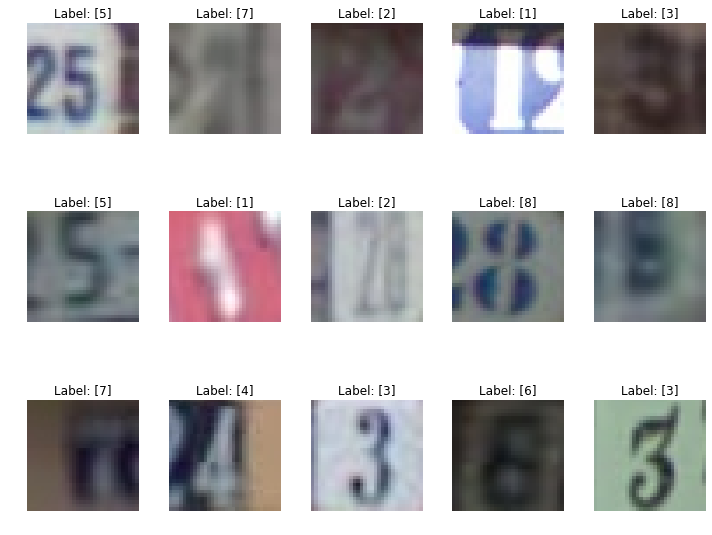

In [5]:
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
        ax.imshow(sample_images[i])
        ax.set_title(f"Label: {sample_labels[i]}")
        ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Convert the training and test images to grayscale
train_images_gs = np.mean(train_images, axis=3, keepdims=True)
test_images_gs = np.mean(test_images, axis=3, keepdims=True)

In [7]:
# Select a random sample of grayscale images and corresponding labels to display
random_indices_gs = np.random.choice(train_images_gs.shape[0], size=15, replace=False)
sample_images_gs = train_images_gs[random_indices_gs]
sample_labels_gs = train_labels[random_indices_gs]

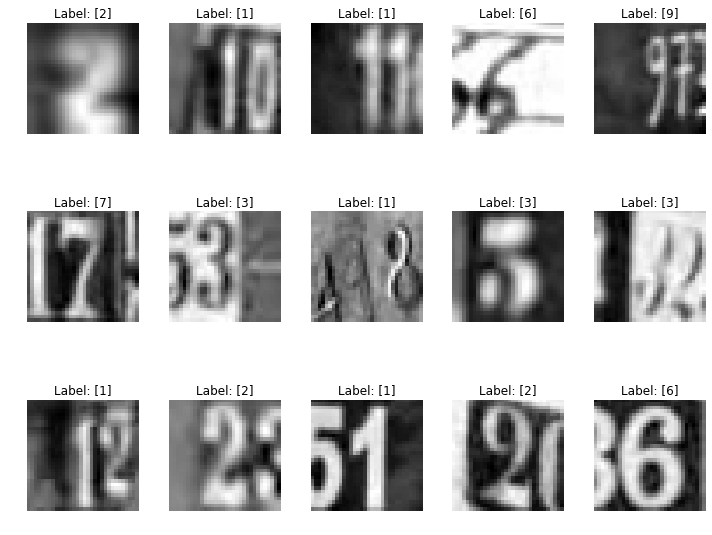

In [8]:
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_images_gs[i, :, :, 0], cmap='gray')
    ax.set_title(f"Label: {sample_labels_gs[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [9]:
# convert label 10
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

In [10]:
# Build the MLP model
MLP_model = Sequential([
    Flatten(input_shape=train_images_gs[0].shape), 
    Dense(256, activation='relu', bias_initializer=initializers.Ones()),   
    Dense(128, activation='relu', bias_initializer=initializers.Ones()),   
    Dense(64, activation='relu', bias_initializer=initializers.Ones()),
    Dense(10, activation='softmax', bias_initializer=initializers.Ones())
    ])
     
# Print the model summary
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile the model
MLP_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # labels are integers
              metrics=['accuracy'])

In [12]:
# Define callbacks
checkpoint_callback_a = ModelCheckpoint(filepath='./checkpoints_mlp_best/checkpoint',
                                      save_weights_only=True,
                                      save_freq='epoch',
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True,
                                      verbose=1)
                                                
early_stopping_callback_a = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)  

In [13]:
# Train the model
history = MLP_model.fit(train_images_gs, train_labels, epochs=20, validation_split=0.15, batch_size=32, 
                        callbacks=[checkpoint_callback_a, early_stopping_callback_a], verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.26044, saving model to ./checkpoints_mlp_best/checkpoint

Epoch 00002: val_accuracy improved from 0.26044 to 0.42624, saving model to ./checkpoints_mlp_best/checkpoint

Epoch 00003: val_accuracy improved from 0.42624 to 0.50878, saving model to ./checkpoints_mlp_best/checkpoint

Epoch 00004: val_accuracy improved from 0.50878 to 0.61816, saving model to ./checkpoints_mlp_best/checkpoint

Epoch 00005: val_accuracy improved from 0.61816 to 0.62444, saving model to ./checkpoints_mlp_best/checkpoint

Epoch 00006: val_accuracy did not improve from 0.62444

Epoch 00007: val_accuracy improved from 0.62444 to 0.62963, saving model to ./checkpoints_mlp_best/checkpoint

Epoch 00008: val_accuracy improved from 0.62963 to 0.68241, saving model to ./checkpoints_mlp_best/checkpoint

Epoch 00009: val_accuracy did not improve from 0.68241

Epoch 00010: val_accuracy improved from 0.68241 to 0.69196, saving model to ./checkpoints_mlp_best/checkpoint

Ep

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = MLP_model.evaluate(test_images_gs, test_labels, verbose=0)

In [15]:
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 1.1458
Test Accuracy: 0.6615


In [16]:
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

for epoch, (loss, accuracy) in enumerate(zip(val_loss, val_accuracy), 1):
    print(f'Epoch {epoch}: Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')

Epoch 1: Validation Loss: 2.1393, Validation Accuracy: 0.2604
Epoch 2: Validation Loss: 1.7241, Validation Accuracy: 0.4262
Epoch 3: Validation Loss: 1.5064, Validation Accuracy: 0.5088
Epoch 4: Validation Loss: 1.2170, Validation Accuracy: 0.6182
Epoch 5: Validation Loss: 1.1838, Validation Accuracy: 0.6244
Epoch 6: Validation Loss: 1.2494, Validation Accuracy: 0.6105
Epoch 7: Validation Loss: 1.1999, Validation Accuracy: 0.6296
Epoch 8: Validation Loss: 1.0340, Validation Accuracy: 0.6824
Epoch 9: Validation Loss: 1.0437, Validation Accuracy: 0.6767
Epoch 10: Validation Loss: 1.0087, Validation Accuracy: 0.6920
Epoch 11: Validation Loss: 1.0686, Validation Accuracy: 0.6690
Epoch 12: Validation Loss: 1.0042, Validation Accuracy: 0.6914
Epoch 13: Validation Loss: 1.0002, Validation Accuracy: 0.6966
Epoch 14: Validation Loss: 1.0616, Validation Accuracy: 0.6735
Epoch 15: Validation Loss: 1.0249, Validation Accuracy: 0.6874
Epoch 16: Validation Loss: 1.0486, Validation Accuracy: 0.6765
E

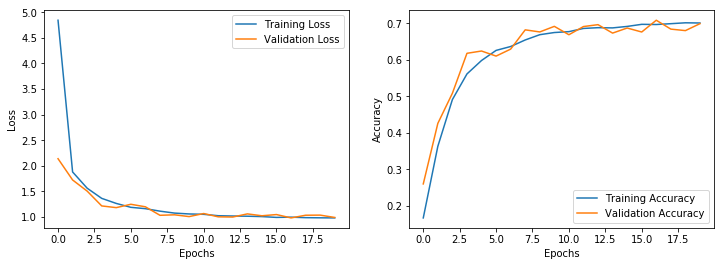

In [17]:
# Plot the learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [18]:
# Define weight decay and dropout rate
weight_decay = 1e-4
dropout_rate = 0.3

CNN_model = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=train_images_gs[0].shape, 
           kernel_regularizer=regularizers.l2(weight_decay), 
           kernel_initializer=initializers.he_uniform()),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(8, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l2(weight_decay), 
           kernel_initializer=initializers.he_uniform()),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    Dense(10, activation='softmax')
])

CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 8)         32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 8)          

In [19]:
CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
checkpoint_callback_b = ModelCheckpoint(filepath='./checkpoints_cnn_best/checkpoint',
                                        save_weights_only=True,
                                        save_freq='epoch',
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True,
                                        verbose=1)
                                                
early_stopping_callback_b = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)                      

In [21]:
history = CNN_model.fit(train_images_gs, train_labels, epochs=10, validation_split=0.15,
                    callbacks=[checkpoint_callback_b, early_stopping_callback_b], verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.79552, saving model to ./checkpoints_cnn_best/checkpoint

Epoch 00002: val_accuracy improved from 0.79552 to 0.83729, saving model to ./checkpoints_cnn_best/checkpoint

Epoch 00003: val_accuracy improved from 0.83729 to 0.84621, saving model to ./checkpoints_cnn_best/checkpoint

Epoch 00004: val_accuracy improved from 0.84621 to 0.86213, saving model to ./checkpoints_cnn_best/checkpoint

Epoch 00005: val_accuracy did not improve from 0.86213

Epoch 00006: val_accuracy improved from 0.86213 to 0.86359, saving model to ./checkpoints_cnn_best/checkpoint

Epoch 00007: val_accuracy improved from 0.86359 to 0.86805, saving model to ./checkpoints_cnn_best/checkpoint

Epoch 00008: val_accuracy improved from 0.86805 to 0.86814, saving model to ./checkpoints_cnn_best/checkpoint

Epoch 00009: val_accuracy did not improve from 0.86814

Epoch 00010: val_accuracy improved from 0.86814 to 0.86941, saving model to ./checkpoints_cnn_best/checkpoint


In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = CNN_model.evaluate(test_images_gs, test_labels, verbose=0)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.5205
Test Accuracy: 0.8586


In [23]:
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

for epoch, (loss, accuracy) in enumerate(zip(val_loss, val_accuracy), 1):
    print(f'Epoch {epoch}: Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')

Epoch 1: Validation Loss: 0.6873, Validation Accuracy: 0.7955
Epoch 2: Validation Loss: 0.5675, Validation Accuracy: 0.8373
Epoch 3: Validation Loss: 0.5341, Validation Accuracy: 0.8462
Epoch 4: Validation Loss: 0.4921, Validation Accuracy: 0.8621
Epoch 5: Validation Loss: 0.5019, Validation Accuracy: 0.8571
Epoch 6: Validation Loss: 0.4867, Validation Accuracy: 0.8636
Epoch 7: Validation Loss: 0.4784, Validation Accuracy: 0.8680
Epoch 8: Validation Loss: 0.4793, Validation Accuracy: 0.8681
Epoch 9: Validation Loss: 0.4708, Validation Accuracy: 0.8678
Epoch 10: Validation Loss: 0.4670, Validation Accuracy: 0.8694


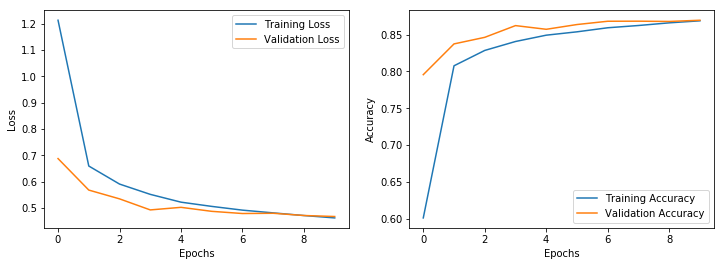

In [24]:
# Plot the learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [25]:
# get best weights for the MLP model 
MLP_model.load_weights('checkpoints_mlp_best/checkpoint')
# get the beset weights for the CNN model
CNN_model.load_weights('checkpoints_cnn_best/checkpoint')

In [26]:
num_test_images = sample_images_gs.shape[0]

index = np.random.choice(num_test_images, 5)
random_test_images_gs = sample_images_gs[index, ...]
random_test_labels = sample_labels_gs[index, ...]

MLP_pred = MLP_model.predict(random_test_images_gs)
CNN_pred = CNN_model.predict(random_test_images_gs)

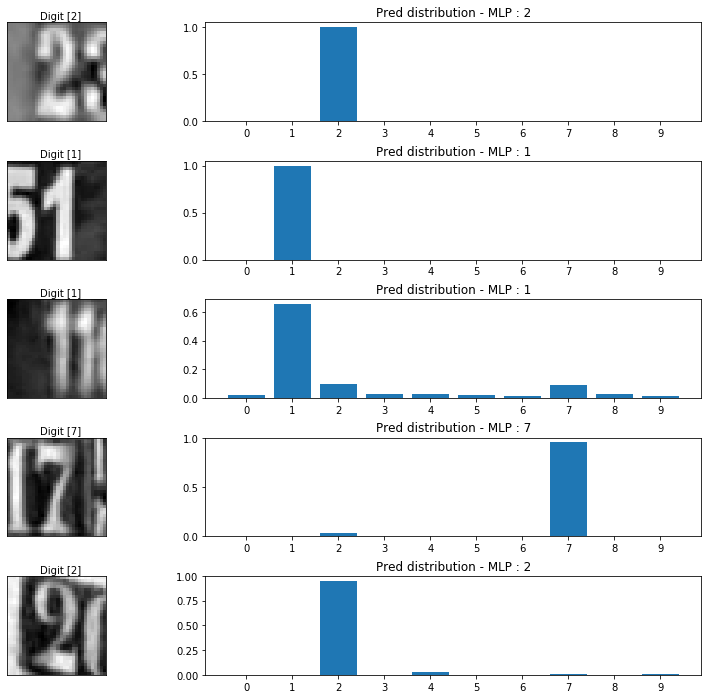

In [27]:
# MLP predictions 
fig, axes = plt.subplots(5, 2, figsize=(16, 12))

fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction_mlp, image, label) in enumerate(zip(MLP_pred, random_test_images_gs, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image), cmap='gray')
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction_mlp)), prediction_mlp)
    axes[i, 1].set_xticks(np.arange(len(prediction_mlp)))
    axes[i, 1].set_title(f"Pred distribution - MLP : {np.argmax(prediction_mlp)}")
    
plt.show()

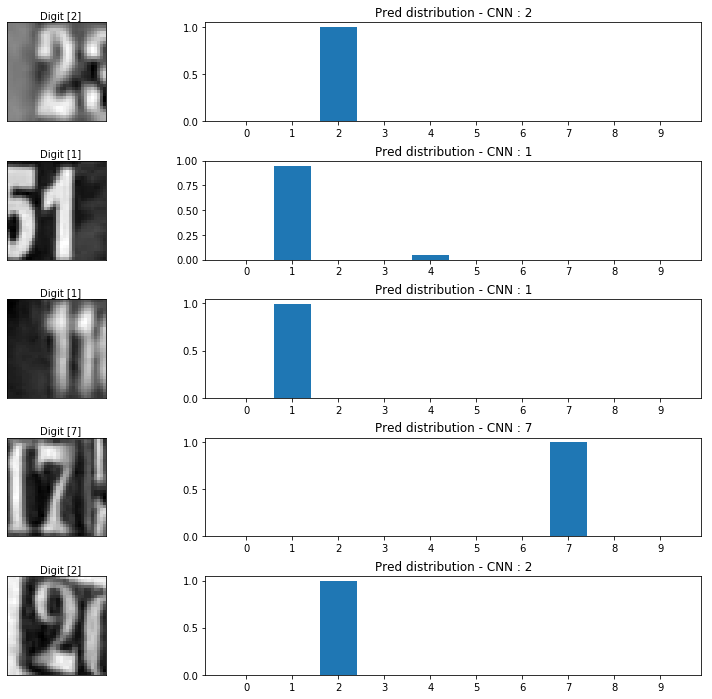

In [28]:
# CNN predictions 
fig, axes = plt.subplots(5, 2, figsize=(16, 12))

fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction_cnn, image, label) in enumerate(zip(CNN_pred, random_test_images_gs, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image), cmap='gray')
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction_cnn)), prediction_cnn)
    axes[i, 1].set_xticks(np.arange(len(prediction_cnn)))
    axes[i, 1].set_title(f"Pred distribution - CNN : {np.argmax(prediction_cnn)}")
    
plt.show()